# Not using Google Drive so, skip it 

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

#### Because we are not running the cell above, run the get_datasets.sh manually

`!bash get_datasets.sh`

# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [2]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [3]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.2120479295080622e-05
W3 relative error: 4.5623278736665505e-07
b1 relative error: 4.6600944653202505e-09
b2 relative error: 2.085654276112763e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 6.862884860440611e-09
W2 relative error: 3.522821562176466e-08
W3 relative error: 2.6171457283983532e-08
b1 relative error: 1.4752427965311745e-08
b2 relative error: 1.7223751746766738e-09
b3 relative error: 2.378772438198909e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 28.474159
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.124000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.121000
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.125000
(Epoch 3 / 20) train acc: 0.720000; val_acc: 0.144000
(Epoch 4 / 20) train acc: 0.820000; val_acc: 0.146000
(Epoch 5 / 20) train acc: 0.940000; val_acc: 0.155000
(Iteration 11 / 40) loss: 0.048634
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.151000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.159000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.152000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.156000
(Iteration 21 / 40) loss: 0.039294
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.156000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.154000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.154000
(Iteration 31 / 40) loss:

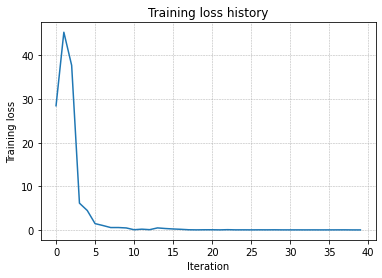

In [4]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 4.3e-2   # Experiment with this!
learning_rate = 4.1e-3  # Experiment with this!
model = FullyConnectedNet(
    hidden_dims = [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 39.544774
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.107000
(Epoch 1 / 20) train acc: 0.280000; val_acc: 0.103000
(Epoch 2 / 20) train acc: 0.220000; val_acc: 0.109000
(Epoch 3 / 20) train acc: 0.520000; val_acc: 0.127000
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.131000
(Epoch 5 / 20) train acc: 0.820000; val_acc: 0.121000
(Iteration 11 / 40) loss: 0.906419
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.132000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.123000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.125000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.120000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.132000
(Iteration 21 / 40) loss: 0.091049
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.131000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.129000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.127000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.129000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.130000
(Iteration 31 / 40) loss:

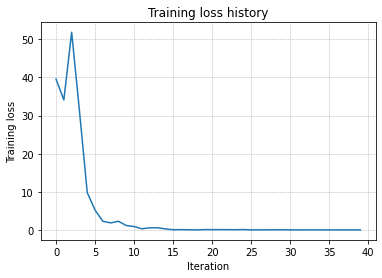

In [5]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 4.7e-3  # Experiment with this!
weight_scale = 7.5e-2   # Experiment with this!
model = FullyConnectedNet(
    hidden_dims = [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1: 
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:

_Working on both networks, and after experiments on weight scale & learning rate - I think a five-layer network is more sensitive than a three-layer network._

_The reason for this sensitivity is the effect of vanishing or exploding gradients. In deeper networks, gradients become very small or very large due to repeated multiplication of weights in each layer._

_If the initialization scale is too large, it can lead to **exploding gradients**, causing the optimization process to become unstable and the network to diverge._ 

_If the initialization scale is too small, it can result in **vanishing gradients**, hindering the training process._ 

_The deeper network has a higher chance of encountering these gradient-related issues, so it is important to carefully choose the initialization scale for deeper networks to ensure stable and efficient training._


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [6]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.104000; val_acc: 0.107000
(Iteration 11 / 200) loss: 2.356070
(Iteration 21 / 200) loss: 2.214091
(Iteration 31 / 200) loss: 2.205928
(Epoch 1 / 5) train acc: 0.225000; val_acc: 0.193000
(Iteration 41 / 200) loss: 2.132095
(Iteration 51 / 200) loss: 2.118950
(Iteration 61 / 200) loss: 2.116443
(Iteration 71 / 200) loss: 2.132549
(Epoch 2 / 5) train acc: 0.298000; val_acc: 0.260000
(Iteration 81 / 200) loss: 1.977227
(Iteration 91 / 200) loss: 2.007528
(Iteration 101 / 200) loss: 2.004762
(Iteration 111 / 200) loss: 1.885342
(Epoch 3 / 5) train acc: 0.343000; val_acc: 0.287000
(Iteration 121 / 200) loss: 1.891517
(Iteration 131 / 200) loss: 1.923677
(Iteration 141 / 200) loss: 1.957743
(Iteration 151 / 200) loss: 1.966736
(Epoch 4 / 5) train acc: 0.322000; val_acc: 0.305000
(Iteration 161 / 200) loss: 1.801483
(Iteration 171 / 200) loss: 1.973779
(Iteration 181 / 200) loss: 1.666572
(Iteration 191 / 200) los

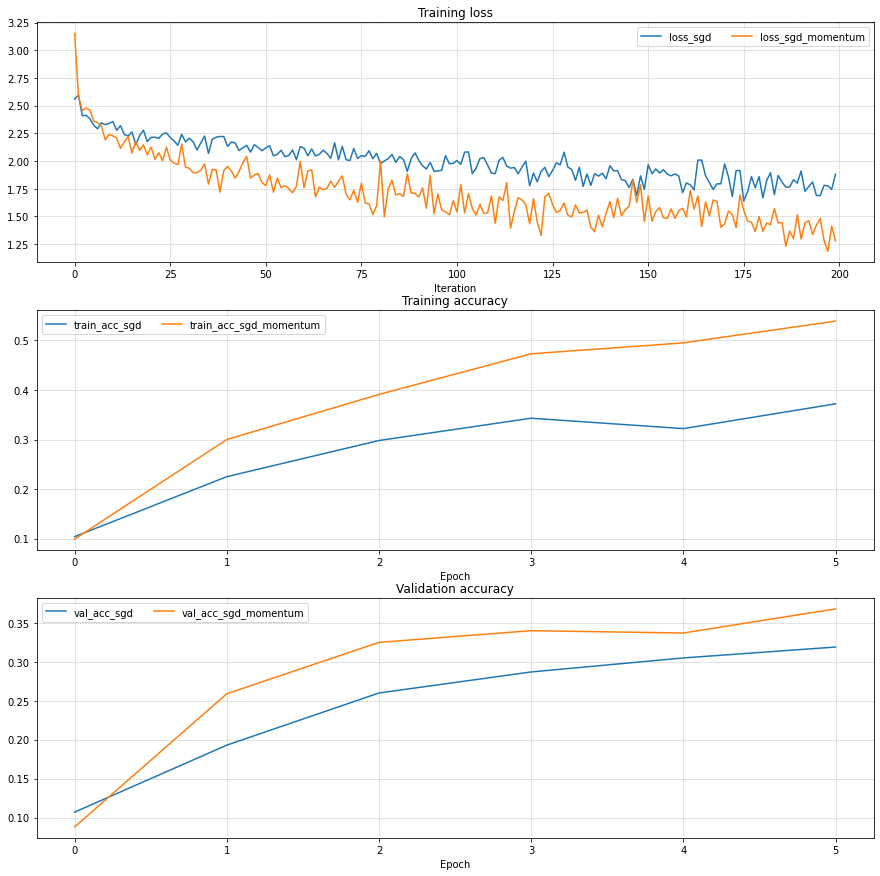

In [7]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [8]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [9]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.027712
(Iteration 21 / 200) loss: 2.183358
(Iteration 31 / 200) loss: 1.744257
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.330000
(Iteration 41 / 200) loss: 1.707951
(Iteration 51 / 200) loss: 1.703835
(Iteration 61 / 200) loss: 2.094758
(Iteration 71 / 200) loss: 1.505558
(Epoch 2 / 5) train acc: 0.419000; val_acc: 0.362000
(Iteration 81 / 200) loss: 1.594429
(Iteration 91 / 200) loss: 1.519017
(Iteration 101 / 200) loss: 1.368523
(Iteration 111 / 200) loss: 1.470400
(Epoch 3 / 5) train acc: 0.460000; val_acc: 0.378000
(Iteration 121 / 200) loss: 1.199064
(Iteration 131 / 200) loss: 1.464705
(Iteration 141 / 200) loss: 1.359863
(Iteration 151 / 200) loss: 1.417470
(Epoch 4 / 5) train acc: 0.521000; val_acc: 0.371000
(Iteration 161 / 200) loss: 1.380564
(Iteration 171 / 200) loss: 1.384368
(Iteration 181 / 200) loss: 1.123532
(Iteration 191 / 200) lo

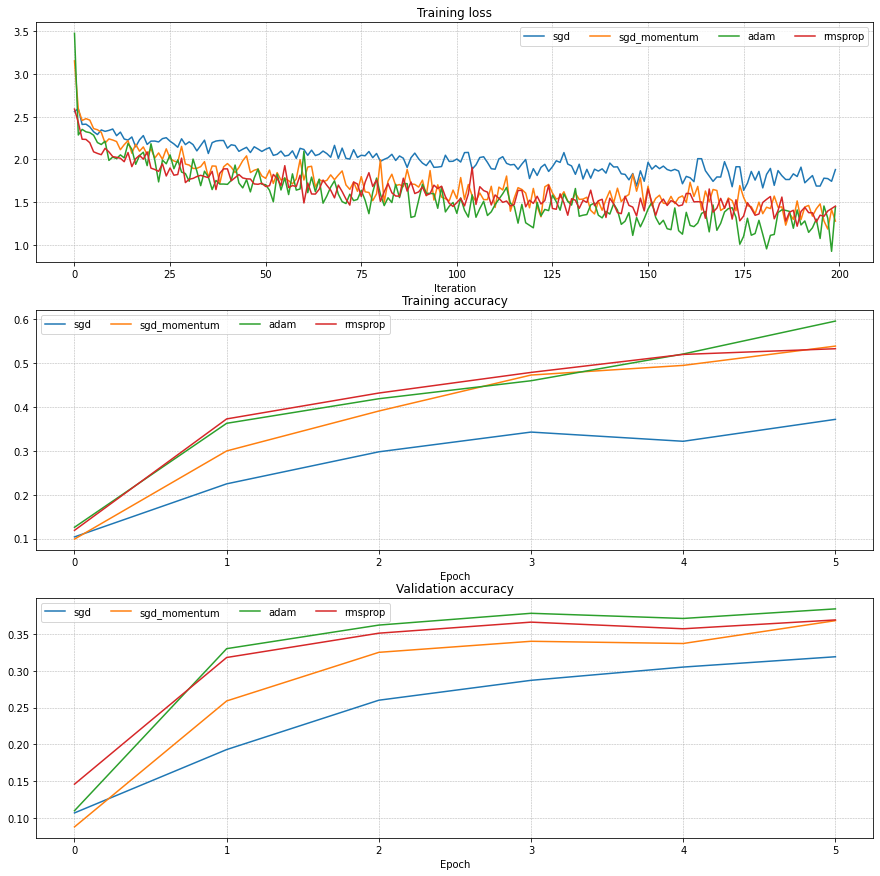

In [10]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 

_Based on the given update rule, if we do not take constant learning rate into account, we are multiplying the gradients with $$-1 / sqrt(cache) + eps$$_

_If cache becomes too big, the update will be really small for the weights._

_In another words, over time, the cache term keeps growing as it accumulates the squared gradients for each update. As this term grows, the denominator of the update fraction gets larger, effectively reducing the magnitude of the weight update._

_Adam addresses this issue in AdaGrad by incorporating an exponentially decaying average of squared gradients along with the current squared gradient. This helps to prevent the learning rate from shrinking too fast for frequently updated parameters._

| Feature | AdaGrad | Adam |
| - |  - | - | 
| Accumulation of squared gradients	| Yes |	Yes (exponentially decaying average) | 
| Impact on learning rate | Shrinks significantly for frequently updated parameters	| Less aggressive reduction in learning rate |



# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [14]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import random
forget = random.randint(0,1)

if forget:
    print("You are at the last question in this notebook")
else:
    print("You remembered!")

# A deep net with batchnorm.
hidden_dims = [100, 100, 100, 100, 100, 100, 100]

weight_scales = np.logspace(2e-2, 1e-1, num=4)
# weight_scale = 2e-2

for _, weight_scale in enumerate(weight_scales):
    
  best_model = FullyConnectedNet(hidden_dims, 
                               weight_scale=weight_scale, 
                               normalization='batchnorm')

  print('Solver with batch norm:')
  # solver automatically stores best model in best_model
  solver = Solver(best_model, data,
                  num_epochs=50, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=True,
                  print_every=5000)
  solver.train()



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

You are at the last question in this notebook
Solver with batch norm:
(Iteration 1 / 49000) loss: 10.335946
(Epoch 0 / 50) train acc: 0.096000; val_acc: 0.102000
(Iteration 21 / 49000) loss: 8.338984
(Iteration 41 / 49000) loss: 8.979968
(Iteration 61 / 49000) loss: 7.393307
(Iteration 81 / 49000) loss: 5.725590
(Iteration 101 / 49000) loss: 5.072992
(Iteration 121 / 49000) loss: 7.239158
(Iteration 141 / 49000) loss: 5.031146
(Iteration 161 / 49000) loss: 5.530681
(Iteration 181 / 49000) loss: 5.019485
(Iteration 201 / 49000) loss: 4.717057
(Iteration 221 / 49000) loss: 4.593712
(Iteration 241 / 49000) loss: 4.977987
(Iteration 261 / 49000) loss: 5.194323
(Iteration 281 / 49000) loss: 3.949640
(Iteration 301 / 49000) loss: 3.661890
(Iteration 321 / 49000) loss: 3.789167
(Iteration 341 / 49000) loss: 4.323318
(Iteration 361 / 49000) loss: 4.077833
(Iteration 381 / 49000) loss: 4.079013
(Iteration 401 / 49000) loss: 3.978416
(Iteration 421 / 49000) loss: 3.122343
(Iteration 441 / 49000)

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [15]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.504
Test set accuracy:  0.48


# Extra - A better Approach for Training (For Curious Minds):

The approach above was not ideal, we **flew blind**. We had to wait for almost 32 minutes with CPU %100. 

We ```do not``` want that, if possible.

Instead of trying to find best parameters on whole data, start with a  small part of the dataset

once you find the best (?) parameters, train on whole data with them:


In [18]:
best_model_2 = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


best_val = -1    # keep track of best validation accuracy
best_params = {} # dict to hold best model parameters
num_train = 500  # amount of training data for tests

# Generate small dataset
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

# We did this in Assignment 1 !

# learning rate
learning_rates = np.geomspace(3*1e-4, 1e-3, 3)

# try regularization strength > 0 
regularization_strengths = np.geomspace(1e-3, 1e-4, 4)

weight_scales = np.geomspace(2e-2, 1e-1, num=3)

from itertools import product

for lr, ws in product(learning_rates, weight_scales):

    print(F"Learning Rate: {lr}, weight scale {ws}")

    best_model_2 = FullyConnectedNet([256, 128, 100],
                              weight_scale=ws,
                              normalization='batchnorm')
    
    solver = Solver(best_model_2, small_data,
                    num_epochs=20, 
                    batch_size=250,
                    update_rule='adam',
                    optim_config={'learning_rate': lr},
                    verbose=True)
    

    # we can just call this method and it will update the parameters 
    # to the best one we have for us
    solver.train()

    # best accuracy
    new_val = solver.best_val_acc # extract best accuracy

    # Save if validation accuracy is the best
    if new_val > best_val:
        best_val = new_val
        best_params = {'lr':lr, 'ws':ws}

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Learning Rate: 0.00030000000000000014, weight scale 0.020000000000000004
(Iteration 1 / 40) loss: 2.310560
(Epoch 0 / 20) train acc: 0.188000; val_acc: 0.145000
(Epoch 1 / 20) train acc: 0.258000; val_acc: 0.167000
(Epoch 2 / 20) train acc: 0.368000; val_acc: 0.195000
(Epoch 3 / 20) train acc: 0.450000; val_acc: 0.224000
(Epoch 4 / 20) train acc: 0.520000; val_acc: 0.255000
(Epoch 5 / 20) train acc: 0.572000; val_acc: 0.273000
(Iteration 11 / 40) loss: 1.953005
(Epoch 6 / 20) train acc: 0.634000; val_acc: 0.282000
(Epoch 7 / 20) train acc: 0.676000; val_acc: 0.288000
(Epoch 8 / 20) train acc: 0.714000; val_acc: 0.289000
(Epoch 9 / 20) train acc: 0.742000; val_acc: 0.302000
(Epoch 10 / 20) train acc: 0.772000; val_acc: 0.307000
(Iteration 21 / 40) loss: 1.734089
(Epoch 11 / 20) train acc: 0.820000; val_acc: 0.325000
(Epoch 12 / 20) train acc: 0.860000; val_acc: 0.317000
(Epoch 13 / 20) train acc: 0.872000; val_acc: 0.312000
(Epoch 14 / 20) train acc: 0.870000; val_acc: 0.306000
(Epoch 1

Best validation accuracy using a small dataset: 0.354


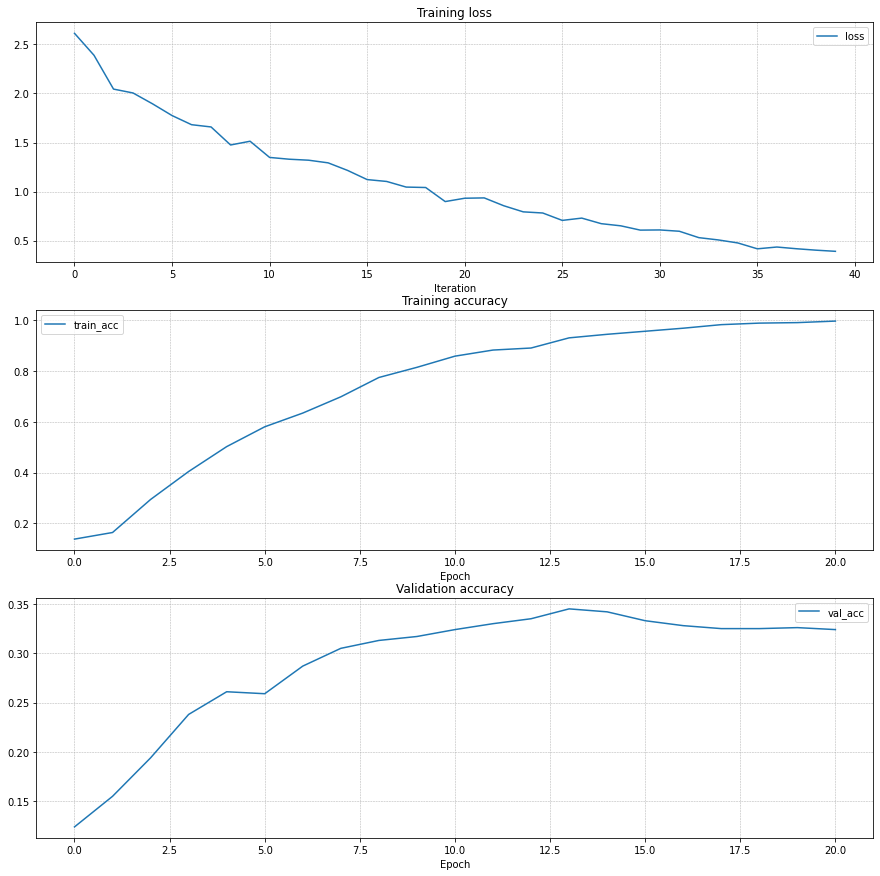

In [23]:
print(f'Best validation accuracy using a small dataset: {best_val}')

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

axes[0].plot(solver.loss_history, label=f"loss")
axes[1].plot(solver.train_acc_history, label=f"train_acc")
axes[2].plot(solver.val_acc_history, label=f"val_acc")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()


In [24]:
# looks promising! 

# lets try to train model with all data now

# Create the best model with the best parameters
best_model_2_big = FullyConnectedNet([256, 128, 100],
                               weight_scale=best_params['ws'],
                               normalization='batchnorm')

# Create solver to train the model on full dataset
solver_2 = Solver(best_model_2_big, data,
                num_epochs=15, batch_size=256,
                update_rule='adam',
                optim_config={'learning_rate': best_params['lr']},
                verbose=False)

solver_2.train() # train the best model

# Print the final validation accuracy acquired with the best model
print(f'Best validation accuracy using full dataset: {solver_2.best_val_acc}')



Best validation accuracy using full dataset: 0.559


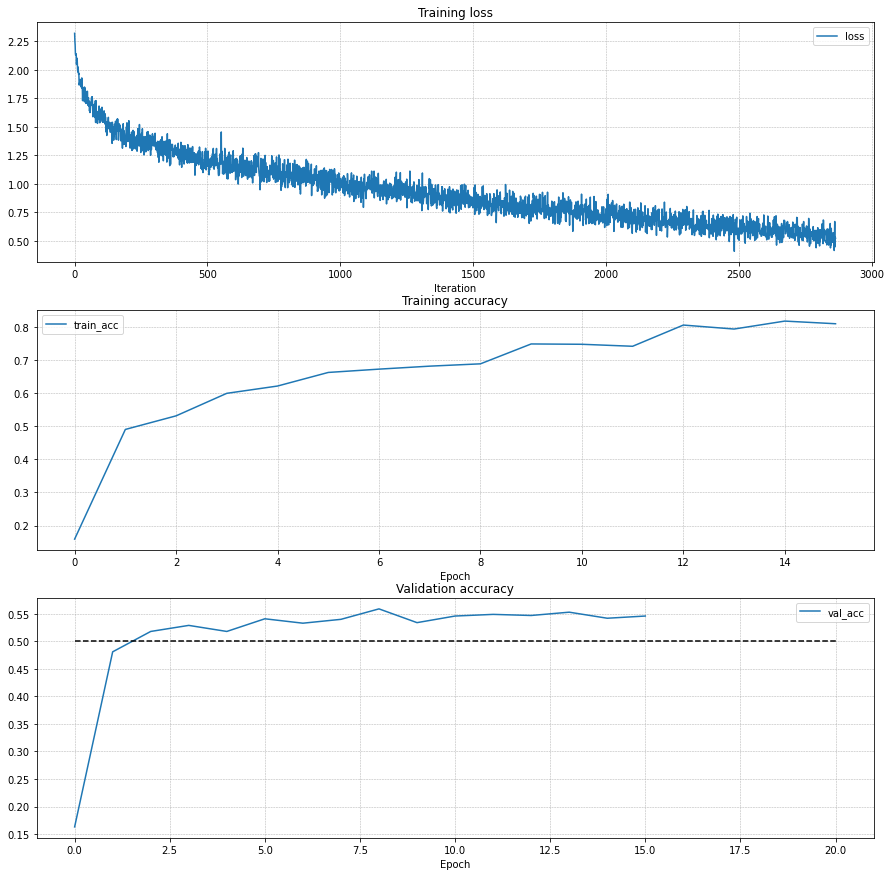

In [26]:
# how does the graph look?
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

axes[0].plot(solver_2.loss_history, label=f"loss")
axes[1].plot(solver_2.train_acc_history, label=f"train_acc")
axes[2].plot(solver_2.val_acc_history, label=f"val_acc")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)
    
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.show()

In [25]:
# how did we do?

y_test_pred = np.argmax(best_model_2_big.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model_2_big.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.534
Test set accuracy:  0.526
